In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
from getContour import getContour
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

## Get CheckMate Output

In [2]:
resultFolder = '../data/checkmate_BS1p'
slhaFolder = '../data/slha_BS1p/'

### Get all analysis names

In [3]:
allAna = []

for resFile in glob.glob(os.path.join(resultFolder,'*','evaluation','total_results.txt')):
    data = np.genfromtxt(resFile,names=True,
            dtype=None,encoding=None)

    ibest = np.argmax(data['rexp'])
    bestAna = data['analysis'][ibest]
    allAna.append(bestAna)
    ibest = np.argmax(data['robs'])
    bestAna = data['analysis'][ibest]
    allAna.append(bestAna)
    ibest = np.argmax(data['robscons'])
    bestAna = data['analysis'][ibest]
    allAna.append(bestAna)
    
    
allAna = sorted(list(set(allAna)))

### Define list of excluded analysis (to be removed from the final/combined exclusion curve)

In [4]:
removeAna = ['atlas_conf_2019_040']

In [5]:
recastData = []
recastDataByAna = dict([[ana,[]] for ana in allAna])
lambdaL = []
lambdaR = []
mLQ = []

kfactor = 1.5

for slhaFile in glob.glob(slhaFolder+'/*.slha'):
    slhaData = pyslha.readSLHAFile(slhaFile)
    mChi1 = slhaData.blocks['MASS'][5000521]
    mDM = slhaData.blocks['MASS'][5000522]
    mLQ.append(slhaData.blocks['MASS'][42])
    lambdaL.append(slhaData.blocks['LQLAML'][(3,3)])
    lambdaR.append(slhaData.blocks['LQLAMR'][(2,3)])
    resDir = os.path.splitext(os.path.basename(slhaFile))[0]
    resFile = os.path.join(resultFolder,resDir,'evaluation',
                'total_results.txt')
    
    #Add point with r=0 to all analyses (default if analysis is missing)
    for ana in recastDataByAna:
        recastDataByAna[ana].append([mChi1,mDM,0.])
    recastData.append([mChi1,mDM,0.])
    
        
    if not os.path.isfile(resFile):
        continue
    data = np.genfromtxt(resFile,names=True,
            dtype=None,encoding=None)

    bestR = 0.0
    for pt in data:
        ana = pt['analysis']
        if not ana in recastDataByAna:
            continue
        r = kfactor*pt['robs']
#         r = kfactor*pt'robscons']
        recastDataByAna[ana][-1][2] = max(r,recastDataByAna[ana][-1][2]) #Set max r-value for point
        if ana in removeAna: continue
        bestR = max(bestR,r)
#     bestR = kfactor*data[np.argmax(data['rexp'])]['robs'] #Use best expected
#     bestR = kfactor*data[np.argmax(data['rexp'])]['robscons']
    recastData[-1][2] = bestR
        

if len(set(mLQ)) != 1:
    print('Multiple leptoquark masses found')
else:
    mLQ = mLQ[0]
if len(set(lambdaR)) != 1:
    print('Multiple values for lambdaR found')
else:
    lambdaR = lambdaR[0]    
if len(set(lambdaL)) != 1:
    print('Multiple values for lambdaL found')
else:
    lambdaL = lambdaL[0]      

In [6]:
recastData = np.array(recastData)
for key,val in recastDataByAna.items():
    recastDataByAna[key] = np.array(val)

In [7]:
excCurve = np.array(getContour(recastData[:,0],recastData[:,0]-recastData[:,1],recastData[:,2],levels=[1.])[1.],dtype=object)
excCurve = sorted(excCurve[:],key = lambda pt: len(pt),reverse=True)[0] #Select longest curve
excCurveAnas = {}
for key,rval in recastDataByAna.items():
    c = getContour(rval[:,0],rval[:,0]-rval[:,1],rval[:,2],levels=[1.])
    if not c:
         excCurveAnas[key]  = []
    else:
        excCurveAnas[key] = np.array(c[1.],dtype=object)


## Plot Curves

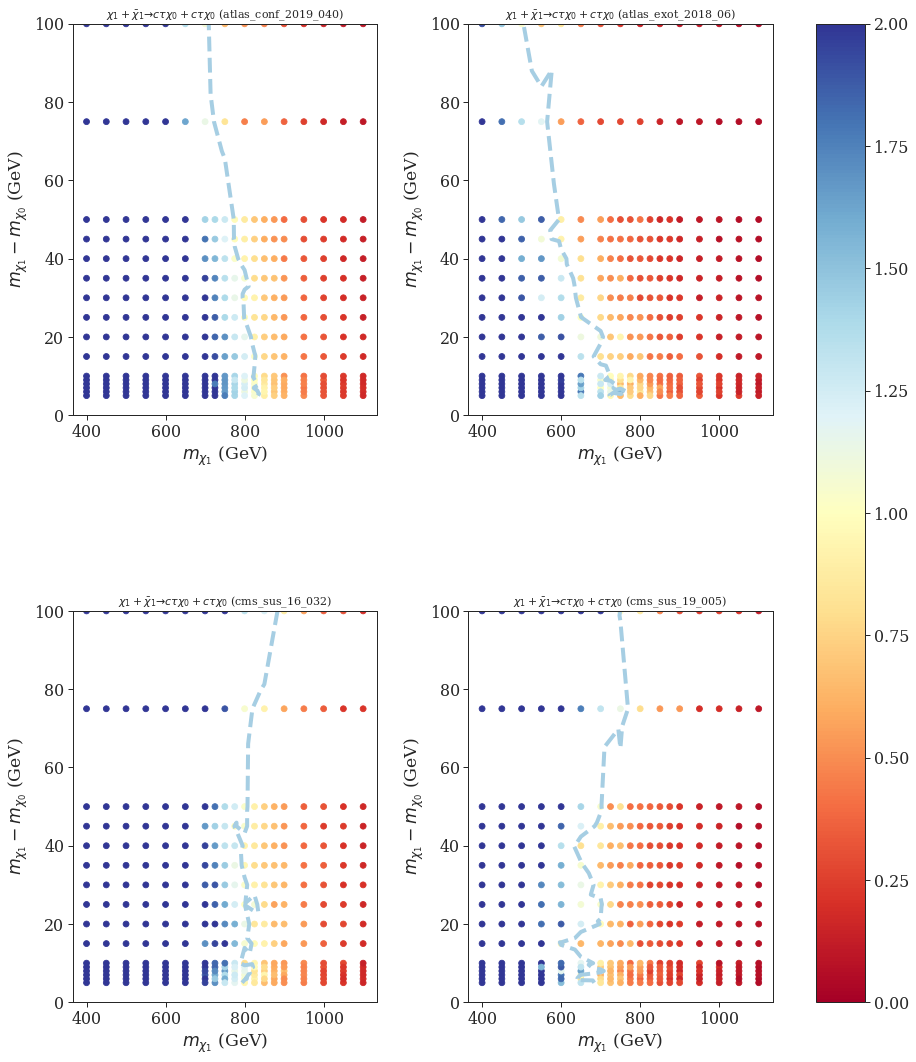

In [8]:
fig, axes = plt.subplots(nrows=int(len(recastDataByAna)/2.), ncols=2, figsize=(18,18))
irow = 0
icolumn = 0
for ana,rData in recastDataByAna.items():
    
    ax = axes[irow,icolumn]
    im = ax.scatter(rData[:,0],rData[:,0]-rData[:,1],c=rData[:,2],
                    s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
    if not ana in excCurveAnas:
        continue
    for i,curve in enumerate(excCurveAnas[ana]):
        if i == 0:
            p = ax.plot(curve[:,0],curve[:,1],label=ana,
                linestyle='--',linewidth=4)
        else:
            ax.plot(curve[:,0],curve[:,1],
                linestyle='--',linewidth=4,c=p[0].get_color())
                
    ax.set_title(r"$\chi_1 + \bar{\chi}_1 \to c \tau \chi_0 + c \tau \chi_0$ (%s)" %ana,fontsize=11)
    ax.set_xlabel(r'$m_{\chi_1}$ (GeV)')    
    ax.set_ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
    ax.set_ylim(0.,100.)
    icolumn += 1
    if icolumn >= 2:
        irow += 1 
        icolumn = 0
             
plt.subplots_adjust(hspace=0.5, wspace=0.3, right=0.8)
cb = fig.colorbar(im, ax=axes[:,:].ravel().tolist())
# plt.tight_layout()
plt.show()

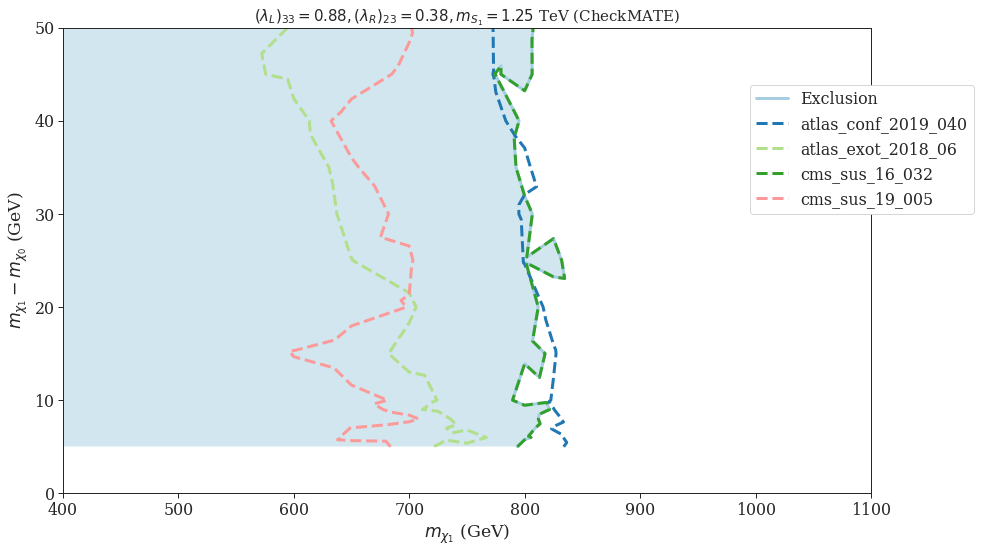

In [9]:
fig = plt.figure(figsize=(14,8))
plt.plot(excCurve[:,0],excCurve[:,1],label='Exclusion',linewidth=3,linestyle='-')
plt.fill_betweenx(excCurve[:,1].tolist(),excCurve[:,0].tolist(),recastData[:,0].min(),alpha=0.5)
for ana,curves in excCurveAnas.items():
    for i,c in enumerate(curves):
        if i == 0:
            p = plt.plot(c[:,0],c[:,1],label=ana,linewidth=3,linestyle='--')
        else:
            plt.plot(c[:,0],c[:,1],linewidth=3,linestyle='--',
                     c=p[0].get_color())


plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
plt.xlim(400.,1100.)
plt.ylim(0,50.)
plt.legend(loc=(0.85,0.6),framealpha=1.0)
plt.title(r"$\left(\lambda_L\right)_{33} = %1.2f, \left(\lambda_R\right)_{23} = %1.2f, m_{S_1} = %1.2f$ TeV (CheckMATE)"
          %(lambdaL,lambdaR,mLQ/1000.0) ,fontsize=15)
plt.tight_layout()
plt.savefig('BS1p_CheckMATE.png')
plt.show()

### Trim data to get smooth curve

In [10]:
#Trim data to get smooth curve
recastDataTrim = []
for pt in recastData:
    if pt[0]-pt[1] in np.arange(0.,260.,20.) or pt[0]-pt[1] < 10.0:
        recastDataTrim.append(pt)
recastDataTrim = np.array(recastDataTrim)
contoursTrim = getContour(recastDataTrim[:,0],recastDataTrim[:,0]-recastDataTrim[:,1],recastDataTrim[:,2],levels=[1.0])
contours = getContour(recastData[:,0],recastData[:,0]-recastData[:,1],recastData[:,2],levels=[1.0])

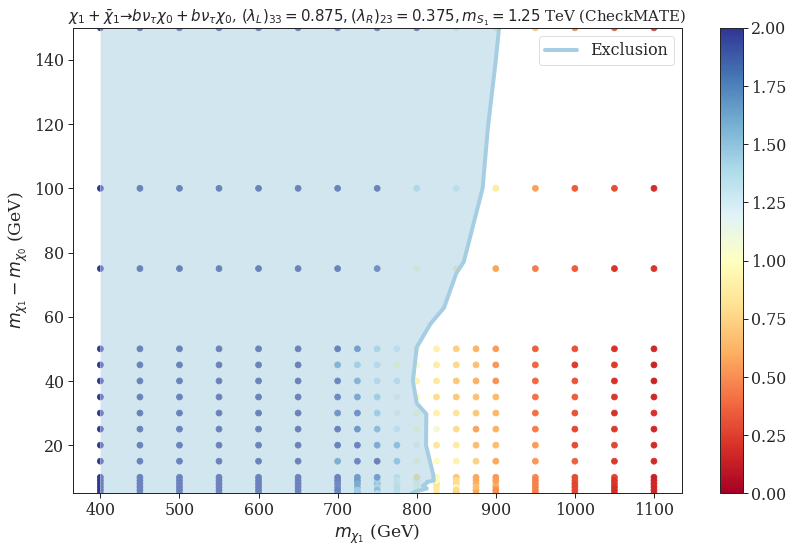

In [11]:
fig = plt.figure(figsize=(12,8))
cp = plt.scatter(recastData[:,0],recastData[:,0]-recastData[:,1],c=recastData[:,2],
                    s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
   
excCurveTrim =  sorted(contoursTrim[1.0], key = lambda pt: len(pt), reverse=True)[0]
excCurve =  sorted(contours[1.0], key = lambda pt: len(pt), reverse=True)[0]
plt.plot(excCurveTrim[:,0],excCurveTrim[:,1],label='Exclusion',
                linestyle='-',linewidth=4)
plt.fill_betweenx(excCurveTrim[:,1],recastData[:,0].min(),excCurveTrim[:,0],alpha=0.5)

cb = plt.colorbar(cp)
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
# plt.xlim(200.,1500.)
plt.ylim(5,150.)
plt.legend()
plt.tight_layout()
plt.title(r"$\chi_1 + \bar{\chi}_1 \to b \nu_\tau \chi_0 + b \nu_\tau \chi_0$, "
          +r"$\left(\lambda_L\right)_{33} = %1.3f, \left(\lambda_R\right)_{23} = %1.3f, m_{S_1} = %1.2f$ TeV (CheckMATE)"
          %(lambdaL,lambdaR,mLQ/1000.0) ,fontsize=15)
plt.tight_layout()
plt.show()

In [12]:
header = 'lambdaL33 = %1.3f, lambdaR23 = %1.3f, mLQ = %1.2f' %(lambdaL,lambdaR,mLQ)
header += '\n mchi1 (GeV), mchi1-mchi0 (GeV)'
np.savetxt('BS1p_exclusion_CheckMATE.txt',excCurveTrim,delimiter=',',header=header)